### tensorflow로 Object Detection 수행하기
* download 받은 SSD+Inception, SSD+Mobilenet 그래프 모델을 이용하여 Tensorflow에서 이미지와 비디오 Object Detectio 수행

In [ ]:
#### ms coco 클래스 아이디와 클래스 명 매핑

In [4]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

#### SSD + Inception으로 단일 이미지 Object Detection

person: 0.9696
person: 0.9660
person: 0.8916
car: 0.8609
car: 0.7223
car: 0.7184
car: 0.7095
person: 0.6298
car: 0.5949
car: 0.5511
Detection 수행 시간:  4.38 초


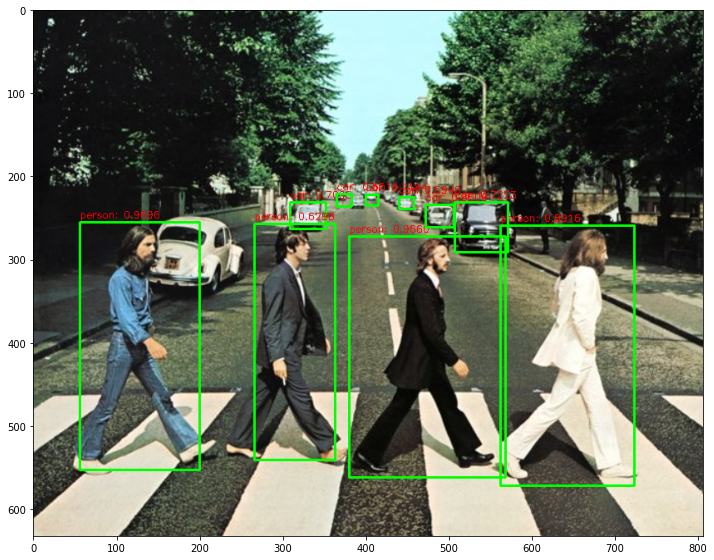

In [5]:
import numpy as np
import tensorflow as tf
import cv2
import time
import matplotlib.pyplot as plt
%matplotlib inline


#inference graph를 읽음. .
with tf.gfile.FastGFile("./pretrained/ssd_inception_v2_coco_2017_11_17/frozen_inference_graph.pb", "rb") as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.Session() as sess:
    # Session 시작하고 inference graph 모델 로딩 
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name="")
    
    # 입력 이미지 생성 및 BGR을 RGB로 변경 
    img = cv2.imread("../../data/image/beatles01.jpg")
    draw_img = img.copy()
    rows = img.shape[0]
    cols = img.shape[1]
    inp = cv2.resize(img, (300,300))
    # OpenCV로 입력받은 BGR 이미지를 RGB 이미지로 변환 
    inp = inp[:,:,[2,1,0]]

    start = time.time()

    # Object Detection 수행. 
    out = sess.run([sess.graph.get_tensor_by_name("num_detections:0"),
                    sess.graph.get_tensor_by_name("detection_scores:0"),
                    sess.graph.get_tensor_by_name("detection_boxes:0"),
                    sess.graph.get_tensor_by_name("detection_classes:0")],
                    feed_dict={"image_tensor:0" : inp.reshape(1, inp.shape[0], inp.shape[1], 3)})

    green_color = (0,255,0)
    red_color = (0,0,255)

    # Bounding Box 시각화 
    # Detect된 Object 별로 bounding box 시각화 
    num_detections = int(out[0][0])
    for i in range(num_detections):
        # class id와 object class score, bounding box정보를 추출
        classId = int(out[3][0][i])
        score = float(out[1][0][i])
        bbox = [float(v) for v in out[2][0][i]]
        if score > 0.4:
            left = bbox[1] * cols
            top = bbox[0] * rows
            right = bbox[3] * cols
            bottom = bbox[2] * rows 

            # cv2의 rectangle(), putText()로 bounding box의 클래스명 시각화 
            cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), green_color, thickness=2)
            caption ="{}: {:.4f}".format(labels_to_names[classId], score)
            print(caption)
            cv2.putText(draw_img, caption, (int(left), int(top-5)), cv2.FONT_HERSHEY_SIMPLEX,0.4, red_color, 1)

    print("Detection 수행 시간: ", round(time.time()-start, 2),"초")

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,12))
plt.imshow(img_rgb)
        

Detection 수행시간: 4.9 초


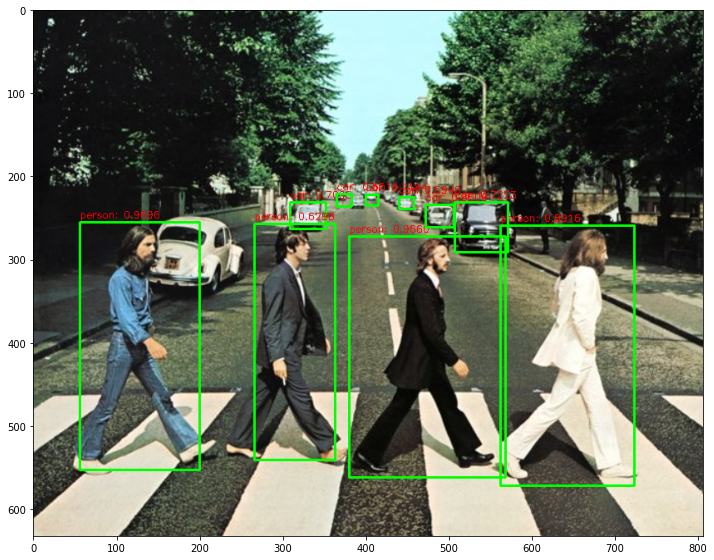

In [6]:
def get_tensor_detected_image(sess, img_array, use_copied_array):
    
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    if use_copied_array:
        draw_img = img_array.copy()
    else:
        draw_img = img_array
    
    inp = cv2.resize(img_array, (300, 300))
    inp = inp[:, :, [2, 1, 0]]  # BGR2RGB
    
    start = time.time()
    # Object Detection 수행. 
    out = sess.run([sess.graph.get_tensor_by_name('num_detections:0'),
                    sess.graph.get_tensor_by_name('detection_scores:0'),
                    sess.graph.get_tensor_by_name('detection_boxes:0'),
                    sess.graph.get_tensor_by_name('detection_classes:0')],
                   feed_dict={'image_tensor:0': inp.reshape(1, inp.shape[0], inp.shape[1], 3)})
    
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    
    # Bounding Box 시각화 
    # Detect된 Object 별로 bounding box 시각화 
    num_detections = int(out[0][0])
    for i in range(num_detections):
        # class id와 object class score, bounding box정보를 추출
        classId = int(out[3][0][i])
        score = float(out[1][0][i])
        bbox = [float(v) for v in out[2][0][i]]
        if score > 0.4:
            left = bbox[1] * cols
            top = bbox[0] * rows
            right = bbox[3] * cols
            bottom = bbox[2] * rows
            # cv2의 rectangle(), putText()로 bounding box의 클래스명 시각화 
            cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), green_color, thickness=2)
            caption = "{}: {:.4f}".format(labels_to_names[classId], score)
            cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)
    
    print('Detection 수행시간:',round(time.time() - start, 3),"초")
    return draw_img

#inference graph를 읽음. .
with tf.gfile.FastGFile('./pretrained/ssd_inception_v2_coco_2017_11_17/frozen_inference_graph.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    
with tf.Session() as sess:
    # Session 시작하고 inference graph 모델 로딩 
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    
    # 입력 이미지 생성, Object Detection된 image 반환, 반환된 image의 BGR을 RGB로 변경 
    img = cv2.imread('../../data/image/beatles01.jpg')
    draw_img = get_tensor_detected_image(sess, img, True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

#### tensorflow로 SSD+ Inception 기반 video Object Detection 수행

In [7]:
video_input_path = '../../data/video/Night_Day_Chase.mp4'
# linux에서 video output의 확장자는 반드시 avi 로 설정 필요. 
video_output_path = '../../data/output/Night_Day_Chase_tensor_ssd_incep01.avi'

cap = cv2.VideoCapture(video_input_path)

codec = cv2.VideoWriter_fourcc(*'XVID')

vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
vid_fps = cap.get(cv2.CAP_PROP_FPS)
    
vid_writer = cv2.VideoWriter(video_output_path, codec, vid_fps, vid_size) 

frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('총 Frame 갯수:', frame_cnt, 'FPS:', vid_fps )

green_color=(0, 255, 0)
red_color=(0, 0, 255)

# SSD+Inception inference graph를 읽음. .
with tf.gfile.FastGFile('./pretrained/ssd_inception_v2_coco_2017_11_17/frozen_inference_graph.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    
with tf.Session() as sess:
    # Session 시작하고 inference graph 모델 로딩 
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    index = 0
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break

        draw_img_frame = get_tensor_detected_image(sess, img_frame, False)
        vid_writer.write(draw_img_frame)
    # end of while loop

vid_writer.release()
cap.release()  


ion 수행시간: 0.087 초
Detection 수행시간: 0.085 초
Detection 수행시간: 0.084 초
Detection 수행시간: 0.086 초
Detection 수행시간: 0.084 초
Detection 수행시간: 0.086 초
Detection 수행시간: 0.085 초
Detection 수행시간: 0.084 초
Detection 수행시간: 0.084 초
Detection 수행시간: 0.083 초
Detection 수행시간: 0.083 초
Detection 수행시간: 0.086 초
Detection 수행시간: 0.085 초
Detection 수행시간: 0.085 초
Detection 수행시간: 0.085 초
Detection 수행시간: 0.086 초
Detection 수행시간: 0.086 초
Detection 수행시간: 0.084 초
Detection 수행시간: 0.084 초
Detection 수행시간: 0.084 초
Detection 수행시간: 0.084 초
Detection 수행시간: 0.084 초
Detection 수행시간: 0.085 초
Detection 수행시간: 0.084 초
Detection 수행시간: 0.084 초
Detection 수행시간: 0.084 초
Detection 수행시간: 0.084 초
Detection 수행시간: 0.084 초
Detection 수행시간: 0.085 초
Detection 수행시간: 0.085 초
Detection 수행시간: 0.087 초
Detection 수행시간: 0.084 초
Detection 수행시간: 0.085 초
Detection 수행시간: 0.086 초
Detection 수행시간: 0.084 초
Detection 수행시간: 0.083 초
Detection 수행시간: 0.086 초
Detection 수행시간: 0.085 초
Detection 수행시간: 0.085 초
Detection 수행시간: 0.085 초
Detection 수행시간: 0.086 초
Detection 수행시간: 0.084 

In [ ]:
# !gsutil cp ../../data/output/Night_Day_Chase_tensor_ssd_incep01.avi gs://my_bucket_dlcv/data/output/Night_Day_Chase_tensor_ssd_incep01.avi

#### SSD+Mobilenet Video Object Detection

In [ ]:
#### 아래 코드는 커널을 재 기동후 바로 수행해야 합니다. 

In [1]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

def get_tensor_detected_image(sess, img_array, use_copied_array):
    
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    if use_copied_array:
        draw_img = img_array.copy()
    else:
        draw_img = img_array
    
    inp = cv2.resize(img_array, (300, 300))
    inp = inp[:, :, [2, 1, 0]]  # BGR2RGB
    

    start = time.time()
    # Object Detection 수행. 
    out = sess.run([sess.graph.get_tensor_by_name('num_detections:0'),
                    sess.graph.get_tensor_by_name('detection_scores:0'),
                    sess.graph.get_tensor_by_name('detection_boxes:0'),
                    sess.graph.get_tensor_by_name('detection_classes:0')],
                   feed_dict={'image_tensor:0': inp.reshape(1, inp.shape[0], inp.shape[1], 3)})
    
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    
    # Bounding Box 시각화 
    # Detect된 Object 별로 bounding box 시각화 
    num_detections = int(out[0][0])
    for i in range(num_detections):
        # class id와 object class score, bounding box정보를 추출
        classId = int(out[3][0][i])
        score = float(out[1][0][i])
        bbox = [float(v) for v in out[2][0][i]]
        if score > 0.3:
            left = bbox[1] * cols
            top = bbox[0] * rows
            right = bbox[3] * cols
            bottom = bbox[2] * rows
            # cv2의 rectangle(), putText()로 bounding box의 클래스명 시각화 
            cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), green_color, thickness=2)
            caption = "{}: {:.4f}".format(labels_to_names[classId], score)
            cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)
    
    print('Detection 수행시간:',round(time.time() - start, 3),"초")
    return draw_img

In [2]:
import numpy as np
import tensorflow as tf
import cv2
import time
import matplotlib.pyplot as plt
%matplotlib inline

video_input_path = '../../data/video/Night_Day_Chase.mp4'
# linux에서 video output의 확장자는 반드시 avi 로 설정 필요. 
video_output_path = '../../data/output/Night_Day_Chase_tensor_ssd_mobile_01.avi'

cap = cv2.VideoCapture(video_input_path)

codec = cv2.VideoWriter_fourcc(*'XVID')

vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
vid_fps = cap.get(cv2.CAP_PROP_FPS)
    
vid_writer = cv2.VideoWriter(video_output_path, codec, vid_fps, vid_size) 

frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('총 Frame 갯수:', frame_cnt, 'FPS:', vid_fps )

green_color=(0, 255, 0)
red_color=(0, 0, 255)

# SSD+Mobilenet inference graph를 읽음. .
with tf.gfile.FastGFile('./pretrained/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    
with tf.Session() as sess:
    # Session 시작하고 inference graph 모델 로딩 
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    index = 0
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break

        draw_img_frame = get_tensor_detected_image(sess, img_frame, False)
        vid_writer.write(draw_img_frame)
    # end of while loop

vid_writer.release()
cap.release()  


ction 수행시간: 0.033 초
Detection 수행시간: 0.035 초
Detection 수행시간: 0.034 초
Detection 수행시간: 0.034 초
Detection 수행시간: 0.035 초
Detection 수행시간: 0.034 초
Detection 수행시간: 0.035 초
Detection 수행시간: 0.034 초
Detection 수행시간: 0.033 초
Detection 수행시간: 0.033 초
Detection 수행시간: 0.032 초
Detection 수행시간: 0.034 초
Detection 수행시간: 0.032 초
Detection 수행시간: 0.033 초
Detection 수행시간: 0.033 초
Detection 수행시간: 0.032 초
Detection 수행시간: 0.032 초
Detection 수행시간: 0.033 초
Detection 수행시간: 0.042 초
Detection 수행시간: 0.033 초
Detection 수행시간: 0.035 초
Detection 수행시간: 0.032 초
Detection 수행시간: 0.032 초
Detection 수행시간: 0.033 초
Detection 수행시간: 0.033 초
Detection 수행시간: 0.031 초
Detection 수행시간: 0.034 초
Detection 수행시간: 0.033 초
Detection 수행시간: 0.04 초
Detection 수행시간: 0.033 초
Detection 수행시간: 0.033 초
Detection 수행시간: 0.032 초
Detection 수행시간: 0.034 초
Detection 수행시간: 0.034 초
Detection 수행시간: 0.032 초
Detection 수행시간: 0.032 초
Detection 수행시간: 0.032 초
Detection 수행시간: 0.033 초
Detection 수행시간: 0.032 초
Detection 수행시간: 0.032 초
Detection 수행시간: 0.033 초
Detection 수행시간: 0.032

In [ ]:
!gsutil cp ../../data/output/Night_Day_Chase_tensor_ssd_mobile_01.avi gs://my_bucket_dlcv/data/output/Night_Day_Chase_tensor_ssd_mobile_01.avi